In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [5]:
X = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/X_USDINR.csv')
X.drop('Unnamed: 0', axis=1, inplace=True)
X.head()

,Deseasonalized_Day_high,Deseasonalized_Day_low,Deseasonalized_Open_price,EMA_50,EMA_100,EMA_200,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,0.002716,0.004312,0.002460,0.000000,0.000000,0.000000,0.0,0.435743,0.428316,0.501290,0.001107,0.000439,0.029707
1,0.003467,0.003890,0.006787,0.000164,0.000083,0.000042,0.0,0.440006,0.429330,0.511641,0.001107,0.000439,0.029707
2,0.000000,0.011124,0.007768,0.000344,0.000177,0.000090,0.0,0.443880,0.431063,0.518980,0.001107,0.000439,0.029707
3,0.000854,0.004946,0.007238,0.000315,0.000165,0.000085,0.0,0.441573,0.431901,0.509839,0.001107,0.000439,0.029707
4,0.003747,0.004596,0.002107,0.000587,0.000307,0.000158,0.0,0.447507,0.433982,0.522539,0.001107,0.000439,0.029707


In [8]:
y = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/Y_USDINR.csv')
y.drop('Unnamed: 0', axis=1, inplace=True)
y.head()

,Closing_price
0,61.400
1,61.495
2,61.508
3,61.391
4,61.565


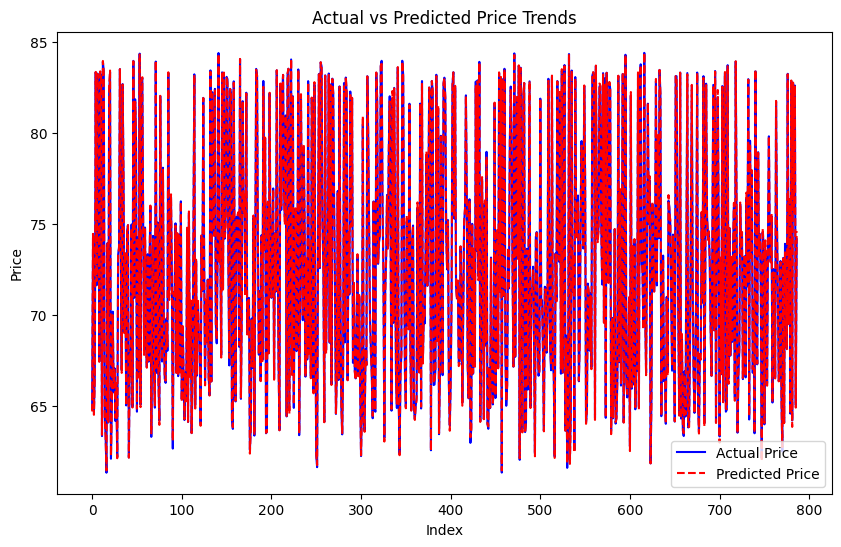

In [21]:
def random_forest_model(X, y):
    rf = RandomForestRegressor()
    rf_metrics = {}

    # Prepare data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit the model
    rf.fit(X_train, y_train)

    # Evaluate the model on training and testing sets
    y_train_pred = rf.predict(X_train).flatten()
    y_test_pred = rf.predict(X_test).flatten()

    # Calculate metrics for training data
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # After calculating the metrics:
    rf_metrics = {
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)", 
            "Accuracy (1 - MAPE)"
        ],
        "Training": [
            train_mae, 
            train_mape * 100, 
            train_r2, 
            (1 - train_mape) * 100
        ],
        "Testing": [
            test_mae, 
            test_mape * 100, 
            test_r2, 
            (1 - test_mape) * 100
        ]
    }

    # Convert to DataFrame
    rf_metrics_df = pd.DataFrame(rf_metrics)

    # Plot actual vs predicted trends
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual Price", color="blue")
    plt.plot(np.arange(len(y_test_pred)), y_test_pred, label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted Price Trends")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    return rf_metrics_df

# Call the function
accuracyTable = random_forest_model(X, y)

In [25]:
def random_forest_model_cv(X, y):
    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor()
    
    # Define the cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV
    
    # Perform cross-validation
    mae_scores = -cross_val_score(rf, X, y, scoring='neg_mean_absolute_error', cv=cv)
    mape_scores = []
    r2_scores = []

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit the model
        rf.fit(X_train, y_train)
        
        # Predict
        y_pred = rf.predict(X_test)
        
        # Calculate metrics
        mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))

    # Average the metrics across folds
    mean_mae = np.mean(mae_scores)
    mean_mape = np.mean(mape_scores)
    mean_r2 = np.mean(r2_scores)

    # After calculating the metrics:
    rf_metrics_cross_validation = {
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)", 
            "Accuracy (1 - MAPE)"
        ],
        "Testing": [
            mean_mae, 
            mean_mape * 100, 
            mean_r2, 
            (1 - mean_mape) * 100
        ]
    }

    # Convert to DataFrame
    rf_metrics_cross_validation = pd.DataFrame(rf_metrics_cross_validation)
    return rf_metrics_cross_validation

# Call the function with your data
rf_metrics_cross_validation = random_forest_model_cv(X, y)

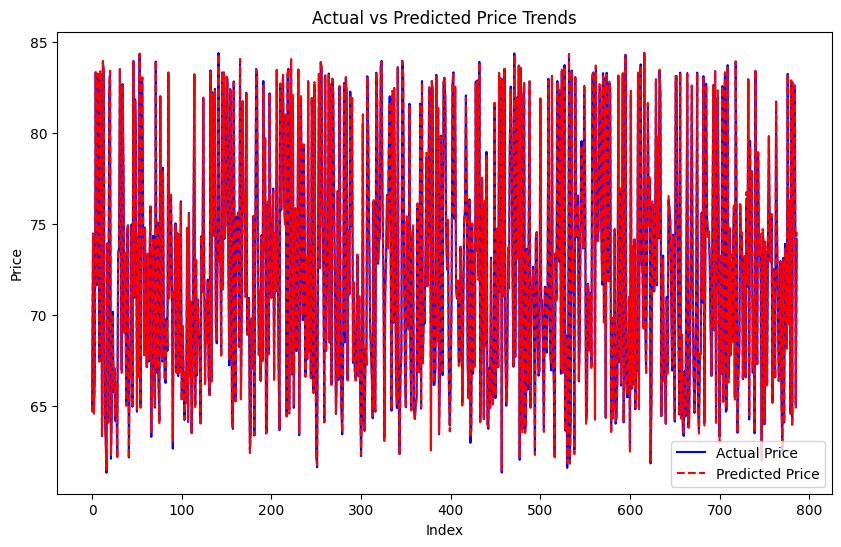

In [26]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
def feature_selection_with_rfe(X, y):
    rf = RandomForestRegressor()
    
    # Recursive Feature Elimination
    rfe = RFE(estimator=rf, n_features_to_select=5)  # Select the top 5 features
    rfe.fit(X, y)

    # Selected features
    selected_features = X.columns[rfe.support_]

    # Reduced Dataset
    X_selected = X[selected_features]
    return X_selected

# Perform feature selection
X_selected = feature_selection_with_rfe(X, y)

# Train the model on selected features
rf_metrics_After_rfe = random_forest_model(X_selected, y)

Accuracy

In [22]:
accuracyTable

,Metric,Training,Testing
0,Mean Absolute Error (MAE),0.034831,0.102067
1,Mean Absolute Percentage Error (MAPE),0.048707,0.143354
2,R-squared (R²),0.999947,0.999570
3,Accuracy (1 - MAPE),99.951293,99.856646


Accuracy with mean of Cross Validation

In [27]:
rf_metrics_cross_validation

,Metric,Testing
0,Mean Absolute Error (MAE),0.095941
1,Mean Absolute Percentage Error (MAPE),0.134193
2,R-squared (R²),0.999599
3,Accuracy (1 - MAPE),99.865807


Acuracy after Feature selection

In [28]:
rf_metrics_After_rfe

,Metric,Training,Testing
0,Mean Absolute Error (MAE),0.034419,0.099800
1,Mean Absolute Percentage Error (MAPE),0.048123,0.140241
2,R-squared (R²),0.999949,0.999588
3,Accuracy (1 - MAPE),99.951877,99.859759
